In [1]:
import pandas as pd
import ast
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import keras

# import a lot of things from keras:
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness
from keras.metrics import categorical_crossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# image size
IMG_SIZE = 28
SIZE = (IMG_SIZE, IMG_SIZE)

# NIST Dataset

In [2]:
NIST_PATH = 'C:/Users/Marc/Desktop/ITT/08/hwr_datasets/subset'

In [22]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_cropped = crop_to_content(img)
    img_resized = cv2.resize(img_cropped, SIZE)
    img_normalized = img_resized.astype('float32') / 255.0
    img_reshaped = img_normalized.reshape(IMG_SIZE, IMG_SIZE, 1)

    return img_reshaped


# Entfernt unnötigen weißen Rand rund um das eigentliche Zeichen
def crop_to_content(img):
    if img.ndim == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(img, 250, 255, cv2.THRESH_BINARY_INV)
    coords = cv2.findNonZero(thresh)
    x, y, w, h = cv2.boundingRect(coords)
    cropped = img[y:y+h, x:x+w]
    
    return cropped

In [23]:
# read nist data set

subset = [ f.path for f in os.scandir(NIST_PATH) if f.is_dir() ]

labels = []
images = []
for folder in subset:
    # folder name is character label but in hex -> we need to convert this for the labels
    label = bytes.fromhex(folder[-2:]).decode('ascii')
    
    print(f'reading data for label: {label}')
    for image_file in os.scandir(folder):  
        if image_file.is_file(): 
            img = cv2.imread(image_file.path)
            preprocessed_img = preprocess_image(img)
            labels.append(label)
            images.append(preprocessed_img)

# Einzigartige Labels erkennen und sortieren
label_names = sorted(list(set(labels)))
print(label_names)

# Image-Labels nummerisch kodieren

labels_numeric = [label_names.index(label) for label in labels]

reading data for label: 0
reading data for label: 1
reading data for label: 2
reading data for label: 3
reading data for label: 4
reading data for label: 5
reading data for label: 6
reading data for label: 7
reading data for label: 8
reading data for label: 9
reading data for label: A
reading data for label: B
reading data for label: C
reading data for label: D
reading data for label: E
reading data for label: F
reading data for label: G
reading data for label: H
reading data for label: I
reading data for label: J
reading data for label: K
reading data for label: L
reading data for label: M
reading data for label: N
reading data for label: O
reading data for label: P
reading data for label: Q
reading data for label: R
reading data for label: S
reading data for label: T
reading data for label: U
reading data for label: V
reading data for label: W
reading data for label: X
reading data for label: Y
reading data for label: Z
reading data for label: a
reading data for label: b
reading data

In [24]:
len(labels)

34906

In [25]:
len(images)

34906

S


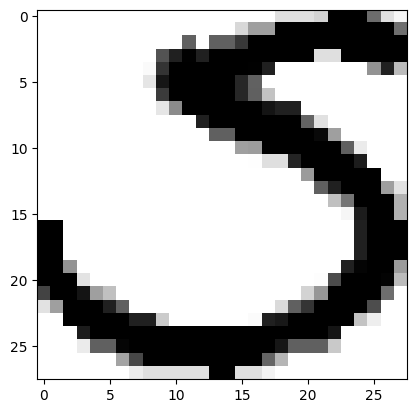

In [27]:
example_index = 20500

print(labels[example_index])
plt.imshow(images[example_index].squeeze(), cmap='gray')

In [28]:
images = np.array(images)
labels_numeric = np.array(labels_numeric)

X_train, X_test, y_train, y_test = train_test_split(images, labels_numeric, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

27924
6982
27924
6982
(27924, 28, 28, 1) (6982, 28, 28, 1) (27924, 62) (6982, 62)


In [29]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'leaky_relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], 1), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

c:\Users\Marc\Desktop\ITT\assignment-07-touch-sensor-Marc-Floeter\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 169s 46ms/step - accuracy: 0.4261 - loss: 2.1042 - val_accuracy: 0.7077 - val_loss: 0.8797 - learning_rate: 0.0010
Epoch 2/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 290s 71ms/step - accuracy: 0.7002 - loss: 0.8944 - val_accuracy: 0.7340 - val_loss: 0.7784 - learning_rate: 0.0010
Epoch 3/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 172s 45ms/step - accuracy: 0.7349 - loss: 0.7869 - val_accuracy: 0.7412 - val_loss: 0.7530 - learning_rate: 0.0010
Epoch 4/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 190s 55ms/step - accuracy: 0.7468 - loss: 0.7460 - val_accuracy: 0.7426 - val_loss: 0.7283 - learning_rate: 0.0010
Epoch 5/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 187s 53ms/step - accuracy: 0.7559 - loss: 0.6956 - val_accuracy: 0.7559 - val_loss: 0.6984 - learning_rate: 0.0010
Epoch 6/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 268s 72ms/step - accuracy: 0.7616 - loss: 0.6886 - val_accuracy: 0.7713 - val_loss: 0.7045 - learning_rate: 0.0010
Epoch 7/50
3491/3491 ━━━━━━━━━━━━━━━━━━━━ 295s 82ms/step -

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 28, 28, 1)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │        51,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │         4,030 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,524 (962.99 KB)

 Trainable params: 82,174 (320.99 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 164,350 (642.00 KB)

In [32]:
model.save('text_recognition.keras')

219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step


c:\Users\Marc\Desktop\ITT\assignment-07-touch-sensor-Marc-Floeter\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Marc\Desktop\ITT\assignment-07-touch-sensor-Marc-Floeter\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Marc\Desktop\ITT\assignment-07-touch-sensor-Marc-Floeter\venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

              precision    recall  f1-score   support

           0       0.56      0.40      0.46       207
           1       0.56      0.74      0.64       250
           2       0.87      0.88      0.87       229
           3       0.98      0.95      0.97       239
           4       0.93      0.97      0.95       206
           5       0.96      0.84      0.90       183
           6       0.91      0.95      0.93       190
           7       0.97      0.95      0.96       238
           8       0.93      0.93      0.93       204
           9       0.82      0.95      0.88       209
           A       0.92      0.88      0.90        78
           B       0.71      0.78      0.74        37
           C       0.80      0.93      0.86       149
           D       0.73      0.76      0.74        59
           E       0.96      0.91      0.93        70
           F       0.82      0.95      0.88       111
           G       0.94      0.79      0.86        19
           H       0.94    

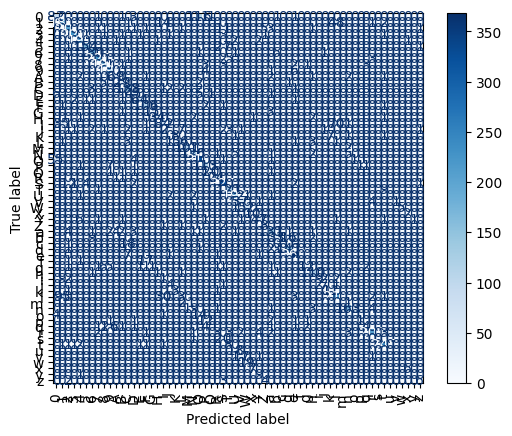

In [33]:
model = keras.models.load_model("text_recognition.keras")

# Vorhersagen für Testdaten erzeugen
y_pred_probs = model.predict(X_test)

# Wahrscheinlichkeits-Vektoren in Klassen-IDs umwandeln
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(test_label, axis=1)

# Confusion Matrix erstellen
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Optional: Anzeigen mit Labelnamen
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(xticks_rotation='vertical', cmap='Blues')

print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))

# IAM Dataset

In [11]:
# dataset from: https://huggingface.co/datasets/Teklia/IAM-line
df = pd.read_csv("IAM_dataset_lines.csv")

In [12]:
df

,Unnamed: 0,text,byte_image
0,0,put down a resolution on the subject,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,1,and he is to be backed by Mr. Will,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,2,nominating any more Labour life Peers,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,3,M Ps tomorrow. Mr. Michael Foot has,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,4,"Griffiths, M P for Manchester Exchange .",b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
...,...,...,...
6477,6477,beside # Catherine . She had the stories open,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
6478,6478,In the train going back to London I sat,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
6479,6479,I wish I went to that school . Did you notice,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
6480,6480,that girl who said hullo to him in the garden ?,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


In [14]:
# decode bytes to image
def img_from_byte_str(byte_str):
    image_bytes = ast.literal_eval(byte_str)
    decoded = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), -1)
    return decoded

A MOVE to stop Mr. Gaitskell from


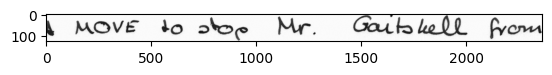

In [16]:
example_index = 6

example_label = df['text'][example_index]
example_img_data = df['byte_image'][example_index]

print(example_label)
img = img_from_byte_str(example_img_data)
plt.imshow(img, cmap="gray")